# Similitud de Documentos

En esta práctica exploraremos dos técnicas fundamentales para la representación y análisis de texto en tareas de procesamiento de lenguaje natural (NLP): **Bag of Words (BoW)** y **TF-IDF (Term Frequency-Inverse Document Frequency)**. Ambas técnicas son ampliamente utilizadas en problemas como la clasificación de texto, análisis de similitud y recuperación de información.

#### ¿Qué es Bag of Words (BoW)?
**BoW** es un modelo simplificado que representa documentos como vectores, donde cada dimensión corresponde a una palabra del vocabulario del corpus y el valor en cada dimensión refleja la frecuencia de aparición de esa palabra en el documento. Aunque es simple, este método es muy eficaz para capturar patrones básicos en el texto y es una base sólida para modelos más avanzados.

#### ¿Qué es TF-IDF?
**TF-IDF** es una extensión del modelo BoW que pondera las palabras en función de su importancia en un documento y su rareza en el corpus completo. Esto ayuda a reducir el peso de palabras comunes (como "el", "y", "de") y resaltar palabras más representativas de cada documento.

La utilidad de estos métodos radica en su capacidad para:
- **Representar documentos como vectores numéricos**, lo que los hace compatibles con algoritmos de aprendizaje automático.
- **Analizar similitudes entre documentos**, identificando relaciones y temas comunes.
- **Clasificar textos**, asignando documentos a categorías basadas en sus características léxicas.

#### Contexto de la práctica
Trabajaremos con un conjunto de documentos relacionados con tecnología móvil y vehículos eléctricos. Estos documentos serán preprocesados mediante tokenización, eliminación de palabras comunes ("stopwords") y representación numérica utilizando BoW y TF-IDF. Esto nos permitirá analizar las similitudes entre los documentos y explorar cómo las palabras clave contribuyen a diferenciar las categorías.

El objetivo final es comparar las representaciones BoW y TF-IDF, observando cómo varían las similitudes entre los documentos según el método usado. Este análisis es crucial para comprender la aplicabilidad de estas técnicas en diferentes escenarios de minería de texto y procesamiento de lenguaje natural.

# Preparación de datos

In [1]:
import os
from docx import Document

import math
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd

Leeremos los documentos de la carpeta `docs`, que contiene una serie de ficheros `docx` con textos relacionados con tecnología móvil y vehículos eléctricos.	

In [2]:
path = "docs/"

Leeremos todos los documentos y los almacenaremos en un diccionario donde la clave será el nombre del documento y el valor será el texto del documento.

In [3]:
def get_document_list():
    global path
    document_list = []
    for file in os.listdir(path):
        if file.endswith(".docx"):
            document_list.append(file)
    return document_list

In [4]:
def extract_text_from_docx(docx_file):
    doc = Document(docx_file)
    text = ""
    for para in doc.paragraphs:
        text += para.text + "\n"
    return text

In [5]:
documents = {}

for docx_file in get_document_list():
    documents[docx_file] = extract_text_from_docx(path + docx_file)

In [6]:
documents

{'doc05.docx': 'Subvenciones estatales impulsan la adopción de vehículos eléctricos\n\nEl gobierno ha anunciado un nuevo paquete de subvenciones para aquellos que decidan comprar un coche eléctrico. Esta medida busca reducir la contaminación y fomentar una movilidad más sostenible. Con la nueva subvención, los compradores podrán beneficiarse de hasta un 25% de descuento en la adquisición de su nuevo vehículo eléctrico. Las empresas automotrices celebran la decisión y esperan un aumento en las ventas en los próximos trimestres.\n\n',
 'doc09.docx': 'Los supercargadores: carga rápida para coches eléctricos\n\nUno de los mayores desafíos de los vehículos eléctricos ha sido el tiempo de carga. Sin embargo, la empresa PowerCharge ha anunciado una nueva red de supercargadores capaces de cargar un coche eléctrico en solo 20 minutos. Estos supercargadores serán instalados en estaciones de servicio y centros comerciales, permitiendo a los conductores recargar sus vehículos en el tiempo que les 

Basta ahora leer por encima el contenido de los documentos para tener una idea de su contenido y de la temática de los mismos. La siguiente lista contiene la categoría de cada documento:

In [7]:
topics = ["Smartphone/alta gama/revolucionar/mercado","duración/batería/smartphones/desafío constante","aplicaciones/móviles/descargadas/mes","futuro/coches/eléctricos/brilla","Subvenciones/estatales/impulsan/adopción/vehículos eléctricos","pantallas/plegables/nueva/tendencia/smartphones","realidad/aumentada/transforma/experiencia/móvil","EcoDrive/coche/eléctrico/económico","supercargadores/carga rápida/coches eléctricos","seguridad móvil","Integración/smartphones/vehículos eléctricos/conducción/conectada", "App/móvil/revoluciona/carga/vehículos eléctricos/ciudad"]
short_topics = ["Smartphone","Smartphone","Smartphone","Car","Car","Smartphone","Smartphone","Car","Car","Smartphone","Car", "Smartphone"]

In [8]:
for i, doc in enumerate(documents.keys()):
    print(f'{doc},', f'label: {topics[i]}')

doc05.docx, label: Smartphone/alta gama/revolucionar/mercado
doc09.docx, label: duración/batería/smartphones/desafío constante
doc08.docx, label: aplicaciones/móviles/descargadas/mes
doc12.docx, label: futuro/coches/eléctricos/brilla
doc04.docx, label: Subvenciones/estatales/impulsan/adopción/vehículos eléctricos
doc03.docx, label: pantallas/plegables/nueva/tendencia/smartphones
doc02.docx, label: realidad/aumentada/transforma/experiencia/móvil
doc01.docx, label: EcoDrive/coche/eléctrico/económico
doc11.docx, label: supercargadores/carga rápida/coches eléctricos
doc07.docx, label: seguridad móvil
doc06.docx, label: Integración/smartphones/vehículos eléctricos/conducción/conectada
doc10.docx, label: App/móvil/revoluciona/carga/vehículos eléctricos/ciudad


Podemos ver cómo existen algunos documentos que no tratan solo sobre telefonía móvil o vehículos eléctricos, sino que abordan ambos temas simultáneamente. Esto es un ejemplo del documento `doc12.docx`, que tiene el siguiente titular: 'App móvil revoluciona la carga de vehículos eléctricos en la ciudad'. Será tarea de nuestro modelo determinar en cual de las categorías encaja mejor este documento.

# Tokenización

Antes de poder construir las representaciones vectoriales de los documentos, necesitamos tokenizar los mismos. La tokenización es el proceso de dividir un texto en unidades más pequeñas, llamadas "tokens", que suelen ser palabras individuales o frases. Este paso es esencial en el procesamiento de lenguaje natural porque permite transformar el texto en una estructura más manejable y adecuada para análisis computacional.

Para ello, haremos uso de la librería `nltk` de Python, que nos proporciona una serie de herramientas para el procesamiento del lenguaje natural que incluyen, entre otras, tokenizadores. Es, además, una herramienta excelente para tareas de preprocesamiento de texto, como la eliminación de signos de puntuación y de palabras comunes o "stop words".

La tokenización es particularmente importante porque:
- **Estandariza los textos**: Permite trabajar con representaciones homogéneas al separar las palabras y normalizarlas, como convertirlas a minúsculas.
- **Elimina ruido**: El preprocesamiento durante la tokenización puede eliminar caracteres especiales, números y palabras irrelevantes, lo que mejora la calidad de las representaciones.
- **Reduce dimensionalidad**: Al eliminar palabras comunes o irrelevantes, como artículos y preposiciones, se logra reducir el tamaño del vocabulario, simplificando el análisis.
- **Facilita la representación vectorial**: Proporciona una base para construir modelos como Bag of Words o TF-IDF, donde las palabras tokenizadas se convierten en dimensiones del vector.

Este proceso es fundamental para garantizar que las representaciones vectoriales reflejen las características relevantes del texto, optimizando así el desempeño de los modelos en tareas como la clasificación o análisis de similitud.

Procedemos, por tanto, a cargar la librería necesaria para realizar la tokenización y a tokenizar los documentos, NLTK, acrónimo de Natural Language Toolkit.

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ricardojuancardenesperez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardojuancardenesperez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Una vez importada la librería, procedemos con el procesamiento de los documentos. Para ello, utilizamos un bucle para tokenizar y preprocesar el contenido de cada documento. Este procesamiento se realiza mediante los siguientes pasos:

- **Tokenización**: Dividimos el texto de cada documento en palabras individuales utilizando nltk.word_tokenize.
Eliminación de caracteres no alfabéticos: Filtramos los tokens para quedarnos solo con palabras que contienen letras, descartando números, signos de puntuación u otros caracteres.
- **Normalización**: Convertimos todas las palabras a minúsculas para garantizar la uniformidad y evitar que la capitalización genere duplicados en el vocabulario.
- **Eliminación de stopwords**: Removemos palabras comunes ("stop words") que no aportan significado al análisis, como artículos y preposiciones, utilizando el conjunto predefinido en nltk para el idioma español.
- **Almacenamiento**: Guardamos las palabras tokenizadas y procesadas en un diccionario (files), donde cada clave corresponde al nombre del documento y el valor es una lista de palabras procesadas.
- **Construcción del vocabulario**: Actualizamos un conjunto global (words) que contiene todas las palabras únicas encontradas en el corpus.

In [ ]:
files = {}
words = set()

for doc in documents:
    doc_words = nltk.word_tokenize(documents[doc])
    doc_words = [word for word in doc_words if word.isalpha()]
    doc_words = [word.lower() for word in doc_words]
    doc_words = [word for word in doc_words if word not in nltk.corpus.stopwords.words('spanish')]
    files[doc] = doc_words

    words = words.union(set(doc_words))

Disponemos ahora de un diccionario con los documentos tokenizados. Cada documento es una lista de palabras que lo componen, donde cada palabra ha sido convertida a minúsculas y se han eliminado los signos de puntuación.

In [11]:
for doc in files:
    print(f'{doc}:', files[doc])

doc01.docx: ['nuevo', 'smartphone', 'alta', 'gama', 'promete', 'revolucionar', 'mercado', 'hoy', 'anunció', 'lanzamiento', 'último', 'smartphone', 'reconocida', 'marca', 'tecnophone', 'nuevo', 'dispositivo', 'denominado', 'tecnophone', 'xz', 'promete', 'características', 'sobresalientes', 'seguramente', 'causarán', 'revuelo', 'industria', 'móvil', 'incorpora', 'pantalla', 'oled', 'pulgadas', 'procesador', 'última', 'generación', 'memoria', 'ram', 'gb', 'además', 'amantes', 'fotografía', 'tecnophone', 'xz', 'posee', 'cámara', 'triple', 'resolución', 'megapíxeles', 'expertos', 'calificado', 'móvil', 'año', 'esperan', 'ver', 'impacto', 'mercado', 'próximos', 'meses']
doc02.docx: ['duración', 'batería', 'smartphones', 'desafío', 'constante', 'vida', 'útil', 'batería', 'convertido', 'temas', 'discutidos', 'mundo', 'smartphones', 'constante', 'demanda', 'aplicaciones', 'servicios', 'consumen', 'grandes', 'cantidades', 'energía', 'fabricantes', 'bajo', 'presión', 'ofrecer', 'soluciones', 'inn

En la lista `words` se almacenan todas las palabras únicas presentes en los documentos, a lo cual llamaremos vocabulario. Este vocabulario será utilizado para construir los vectores BoW de los documentos. ¿Por qué? Porque cada dimensión de los vectores representará una palabra del vocabulario, y el valor en esa dimensión será la frecuencia de esa palabra en el documento, de una manera u otra.

In [12]:
list(words)[:10]

['consumen',
 'vehículo',
 'realizar',
 'lanzamiento',
 'presentes',
 'semana',
 'cercanas',
 'megapíxeles',
 'convergiendo',
 'tecnophone']

Como se demuestra en el siguiente chunk de código, el vocabulario contiene 409 palabras únicas tras el preprocesamiento de los documentos.

In [13]:
len(words)

409

# BOW (Bag of Words)

BoW es un modelo que representa los documentos como vectores en los que cada dimensión corresponde a una palabra del vocabulario y el valor en esa dimensión representa la frecuencia de esa palabra en el documento. Es especialmente útil en tareas de procesamiento de lenguaje natural y minería de texto, ya que permite convertir texto en una forma que puede ser analizada y procesada por algoritmos de aprendizaje automático. Un ejemplo de su uso es el análisis de sentimientos, la clasificación de texto, la recuperación de información, etc.

Para aplicar BoW, primero necesitamos construir un vector para cada documento en el, aunque pequeño, corpus. Cada vector tendrá una longitud igual al tamaño del vocabulario y contendrá la frecuencia de cada palabra en el documento. El resultado será una matriz donde cada fila representa un documento y cada columna representa una palabra del vocabulario, por lo que la matriz tendrá dimensiones (número de documentos, tamaño del vocabulario).

La construcción de la matriz BoW comienza con la creación de una matriz vacía, donde cada fila representa un documento y cada columna corresponde a una palabra única del vocabulario. Posteriormente, para cada documento en el corpus, se recorre su lista de palabras procesadas. Por cada palabra encontrada en el documento, se incrementa el valor en la posición correspondiente de la matriz, utilizando como índice la posición de la palabra en el vocabulario.

In [14]:
bow_vectors = torch.zeros(len(files), len(words))
for i, file in enumerate(files.keys()):
    for word in files[file]:
        bow_vectors[i][list(words).index(word)] += 1

In [15]:
bow_vectors

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

Cada entrada en la matriz refleja la frecuencia de aparición de una palabra específica en un documento determinado. El resultado es una representación vectorial numérica del texto, donde la importancia de una palabra en un documento está directamente relacionada con la cantidad de veces que aparece en él.

Una vez obtenida la matriz BoW, podemos ver qué palabras aparecen en cada documento y con qué frecuencia. Por ejemplo, podemos ver que palabras aparecen en el documento `doc1.docx` y con qué frecuencia.

In [16]:
word_freq_doc01 = bow_vectors[0]
for i, word in enumerate(words):
    if word_freq_doc01[i] > 0:
        print(f'{word}: {word_freq_doc01[i]}')

lanzamiento: 1.0
megapíxeles: 1.0
tecnophone: 3.0
características: 1.0
nuevo: 2.0
alta: 1.0
dispositivo: 1.0
procesador: 1.0
incorpora: 1.0
sobresalientes: 1.0
pulgadas: 1.0
triple: 1.0
gb: 1.0
seguramente: 1.0
posee: 1.0
reconocida: 1.0
gama: 1.0
próximos: 1.0
fotografía: 1.0
causarán: 1.0
promete: 2.0
última: 1.0
último: 1.0
expertos: 1.0
revolucionar: 1.0
cámara: 1.0
smartphone: 2.0
además: 1.0
memoria: 1.0
industria: 1.0
amantes: 1.0
resolución: 1.0
mercado: 2.0
revuelo: 1.0
pantalla: 1.0
marca: 1.0
ram: 1.0
ver: 1.0
esperan: 1.0
impacto: 1.0
denominado: 1.0
oled: 1.0
móvil: 2.0
año: 1.0
meses: 1.0
hoy: 1.0
xz: 2.0
anunció: 1.0
calificado: 1.0
generación: 1.0


Al ver las palabras que aparecen en el documento `doc1.docx`, podemos observar que se trata de un documento relacionado con la tecnología móvil, ya que contiene palabras como 'móvil', 'procesador', 'cámara', 'batería', etc. Además, obtenemos cierta información relevante, como que `tecnophone` es la palabra más frecuente.

La idea ahora es calcular cuales son los vectores más parecidos entre sí y cuales los menos parecidos, lo cual será útil al añadir nuevos documentos no etiquetados al corpus, para determinar a qué categoría pertenecen en función de la similitud con los documentos ya existentes. Si calculamos estas similitudes, obtenemos lo siguiente:

In [17]:
bow_similarities = F.cosine_similarity(bow_vectors.unsqueeze(1), bow_vectors.unsqueeze(0), dim=2)

Vemos como se ha utilizado la similitud coseno para evaluar la relación entre los vectores de BoW correspondientes a los documentos. La similitud del coseno es una métrica comúnmente utilizada en el procesamiento de texto, ya que mide el ángulo entre dos vectores en lugar de su distancia euclidiana. Esto la hace particularmente útil para comparar documentos en términos de su contenido, independientemente de la longitud total del texto.

En este contexto, la similitud del coseno se calcula como el producto escalar de dos vectores dividido por el producto de sus magnitudes. El resultado oscila entre 0 y 1 (si trabajamos solo con valores positivos), donde 1 indica máxima similitud (vectores idénticos en dirección) y valores cercanos a 0 indican una baja similitud.

Al aplicar esta métrica a nuestra matriz de BoW:
- Los elementos de la **diagonal principal** de la matriz de similitudes tienen un valor de 1, ya que cada documento es perfectamente similar a sí mismo.
- Los valores fuera de la diagonal reflejan el grado de similitud entre diferentes documentos. Por ejemplo, documentos con palabras clave comunes o temas similares tendrán valores de similitud más altos.

Este análisis es crucial cuando se introducen nuevos documentos no etiquetados en el corpus. Al calcular sus similitudes con los documentos ya categorizados, podemos asignarles etiquetas basándonos en los temas predominantes de los documentos más similares. Esto es especialmente útil para problemas como la clasificación automática de texto o la recomendación de contenidos.

En términos prácticos, la matriz de similitud nos permite identificar:
- **Grupos temáticos**: Conjuntos de documentos con alta similitud entre sí.
- **Documentos aislados**: Aquellos con baja similitud respecto a otros, que podrían representar temas únicos o menos explorados en el corpus.

A conitnuación, se muestra la matriz de similitud de los documentos basada en la representación BoW.

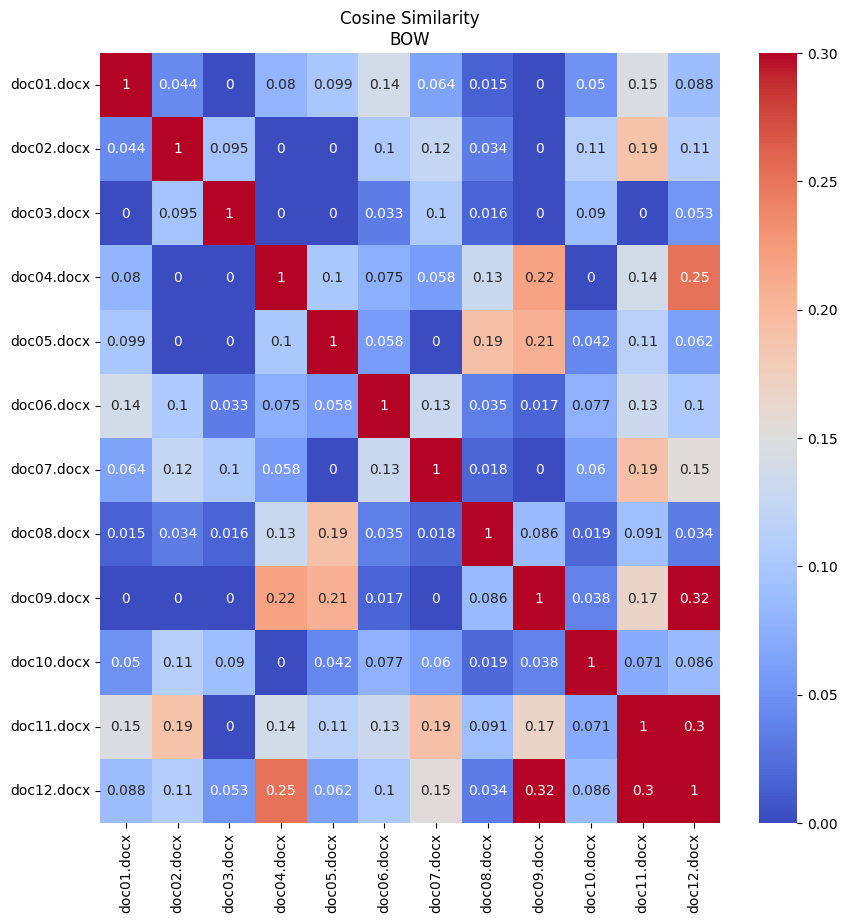

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(bow_similarities, 
            xticklabels=documents.keys(), 
            yticklabels=documents.keys(), 
            annot=True, 
            cmap="coolwarm",
            vmin=0,
            vmax=0.3)

plt.title("Cosine Similarity\nBOW")
plt.show()

Ahora sí, vemos cómo la matriz de similitud de BoW nos proporciona información valiosa sobre las relaciones entre los documentos. Por ejemplo, los documentos `doc1.docx` y `doc2.docx` tienen una similitud del 0.044, lo que indica que comparten muy pocas palabras clave o temas comunes. Por otro lado, `doc1.docx` y `doc11.docx` tienen una similitud del 0.15, lo que sugiere que estos documentos son más parecidos entre sí.

A conitnuación, mostramos cuáles son los documentos más parecidos entre sí.

In [ ]:
similarity_threshold = 0.13
sim_no_diag = bow_similarities - torch.eye(len(bow_similarities))
sim_triang = torch.triu(sim_no_diag, diagonal=1)

df = pd.DataFrame(sim_triang.numpy(), columns=documents.keys(), index=documents.keys())
df = df.stack().reset_index()
df.columns = ['Document 1', 'Document 2', 'Similarity']

df = df[df['Similarity'] > similarity_threshold]
df = df.sort_values(by='Similarity', ascending=False)

df['Topic 1'] = df['Document 1'].apply(lambda x: topics[list(documents.keys()).index(x)])
df['Topic 2'] = df['Document 2'].apply(lambda x: topics[list(documents.keys()).index(x)])

df

,Document 1,Document 2,Similarity,Topic 1,Topic 2
107,doc09.docx,doc12.docx,0.322561,supercargadores/carga rápida/coches eléctricos,App/móvil/revoluciona/carga/vehículos eléctric...
131,doc11.docx,doc12.docx,0.303057,Integración/smartphones/vehículos eléctricos/c...,App/móvil/revoluciona/carga/vehículos eléctric...
47,doc04.docx,doc12.docx,0.251231,futuro/coches/eléctricos/brilla,App/móvil/revoluciona/carga/vehículos eléctric...
44,doc04.docx,doc09.docx,0.218761,futuro/coches/eléctricos/brilla,supercargadores/carga rápida/coches eléctricos
56,doc05.docx,doc09.docx,0.206703,Subvenciones/estatales/impulsan/adopción/vehíc...,supercargadores/carga rápida/coches eléctricos
82,doc07.docx,doc11.docx,0.191297,realidad/aumentada/transforma/experiencia/móvil,Integración/smartphones/vehículos eléctricos/c...
55,doc05.docx,doc08.docx,0.191180,Subvenciones/estatales/impulsan/adopción/vehíc...,EcoDrive/coche/eléctrico/económico
22,doc02.docx,doc11.docx,0.189238,duración/batería/smartphones/desafío constante,Integración/smartphones/vehículos eléctricos/c...
106,doc09.docx,doc11.docx,0.166763,supercargadores/carga rápida/coches eléctricos,Integración/smartphones/vehículos eléctricos/c...
83,doc07.docx,doc12.docx,0.154022,realidad/aumentada/transforma/experiencia/móvil,App/móvil/revoluciona/carga/vehículos eléctric...


Por otra parte, el siguiente chunk de código muestra los documentos más parecidos a cada documento en función de la similitud de BoW.

In [19]:
for i in range(len(bow_similarities)):
    print(f"El documento {i+1} es sobre: {topics[i]}")
    most_similar = torch.topk(bow_similarities[i], 4, largest=True)
    for j in range(len(most_similar.indices) - 1):
        print(f"El documento más similar es el {most_similar.indices[j+1] + 1} ({topics[most_similar.indices[j+1]]}) con una similitud de {most_similar.values[j+1]}")
    print("\n")

El documento 1 es sobre: Smartphone/alta gama/revolucionar/mercado
El documento más similar es el 11 (Integración/smartphones/vehículos eléctricos/conducción/conectada) con una similitud de 0.14693252742290497
El documento más similar es el 6 (pantallas/plegables/nueva/tendencia/smartphones) con una similitud de 0.13795633614063263
El documento más similar es el 5 (Subvenciones/estatales/impulsan/adopción/vehículos eléctricos) con una similitud de 0.09933991730213165


El documento 2 es sobre: duración/batería/smartphones/desafío constante
El documento más similar es el 11 (Integración/smartphones/vehículos eléctricos/conducción/conectada) con una similitud de 0.18923771381378174
El documento más similar es el 7 (realidad/aumentada/transforma/experiencia/móvil) con una similitud de 0.1242886409163475
El documento más similar es el 10 (seguridad móvil) con una similitud de 0.11088317632675171


El documento 3 es sobre: aplicaciones/móviles/descargadas/mes
El documento más similar es el 

# TF-IDF

Procedemos ahora a calcular los vectores TF-IDF de los documentos. TF-IDF (Term Frequency-Inverse Document Frequency) es una medida que evalúa la importancia de una palabra en un documento en relación con un corpus. Es el producto de dos términos: la frecuencia de la palabra en el documento (TF) y la inversa de la frecuencia de la palabra en el corpus (IDF). Mateáticamente, se calcula de la siguiente manera:

$$ \text{TF-IDF} = \text{TF} \times \text{IDF} $$

donde:

- $ \text{TF} = \frac{\text{Número de veces que la palabra aparece en el documento}}{\text{Número total de palabras en el documento}} $

- $ \text{IDF} = \log\left(\frac{\text{Número total de documentos}}{\text{Número de documentos que contienen la palabra}}\right) $

El resultado es un vector que representa el documento, donde cada dimensión corresponde a una palabra del vocabulario y el valor en esa dimensión es el TF-IDF de esa palabra en el documento. Este vector es una representación más sofisticada que el BoW, ya que no solo tiene en cuenta la frecuencia de las palabras en el documento, sino también la importancia de la palabra en el corpus.

In [21]:
def tf(word, document):
    return document.count(word) / len(document)

In [22]:
def idf(word, documents):
    total_documents = len(documents)
    count = 0

    for doc in documents:
        if word in documents[doc]:
            count += 1

    return math.log(total_documents / count)

In [23]:
def tf_idf(word, document, documents):
    return tf(word, document) * idf(word, documents)

Procemos con el cálculo de los vectores tal y como se hizo con BoW. Para ello, partiremos de una matriz vacía, donde cada fila corresponde con un documento y cada columna con una palabra del vocabulario. Posteriormente, para cada documento en el corpus, se recorre su lista de palabras procesadas. Por cada palabra, se calcula su TF-IDF y se actualiza el valor en la matriz.

El resultado de esta matriz será una representación numérica de los documentos basada en la importancia de las palabras, no solo en el documento, sino también en el corpus completo. Esto nos permitirá analizar las similitudes entre los documentos de una manera más sofisticada que con BoW.

In [24]:
bow_tf_idf_vects = torch.zeros(len(documents), len(words))
bow_tf_idf_vects.require_grad = False
bow_tf_idf_vects.shape

torch.Size([12, 409])

In [25]:
for word in words:
    for i, doc in enumerate(documents):
        bow_tf_idf_vects[i, list(words).index(word)] = tf_idf(word, files[doc], files)

Una vez obtenidas estas representaciones, calculamos las similitudes entre documentos mediante la similitud coseno, tal y como se hizo con BoW.

In [26]:
tf_idf_similarities = F.cosine_similarity(bow_tf_idf_vects.unsqueeze(1), bow_tf_idf_vects.unsqueeze(0), dim=2)

Por último, graficamos las similitudes entre los documentos utilizando los vectores TF-IDF, obteniendo el siguiente resultado:

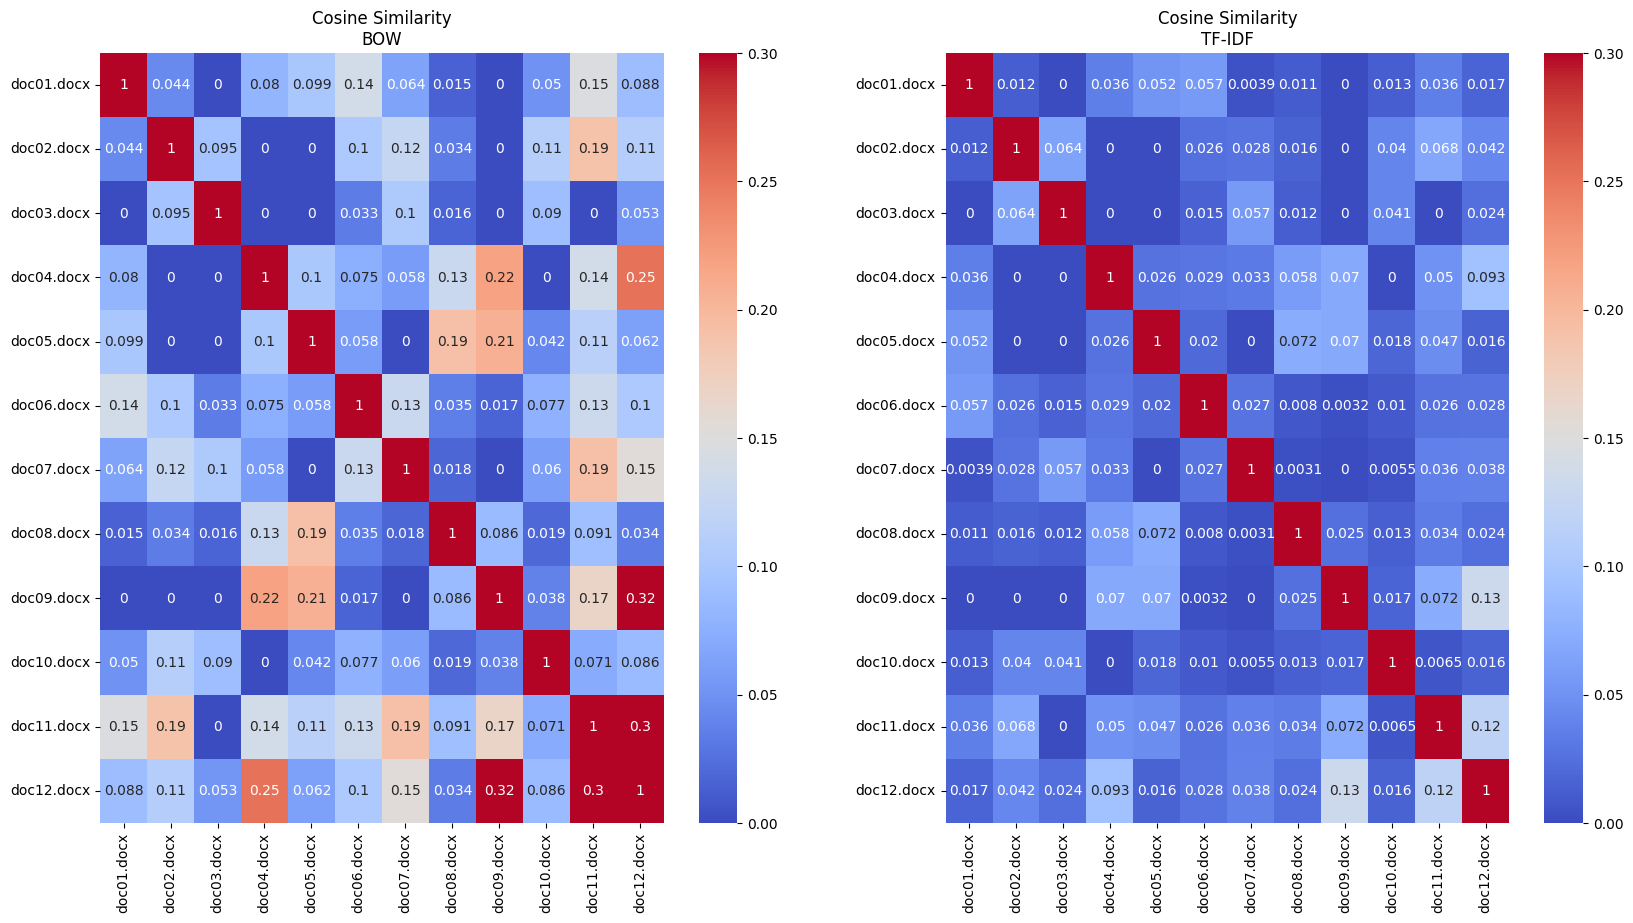

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(bow_similarities,
            xticklabels=documents.keys(),
            yticklabels=documents.keys(),
            annot=True,
            cmap="coolwarm",
            vmin=0,
            vmax=0.3,
            ax=ax[0])

sns.heatmap(tf_idf_similarities,
            xticklabels=documents.keys(),
            yticklabels=documents.keys(),
            annot=True,
            cmap="coolwarm",
            vmin=0,
            vmax=0.3,
            ax=ax[1])

ax[0].set_title("Cosine Similarity\nBOW")
ax[1].set_title("Cosine Similarity\nTF-IDF")

plt.show()

Podemos apreciar cómo los resultados son similares a los obtenidos con BoW, aunque podemos apreciar ligeras diferencias. A simple vista, el método TF-IDF parece encontrar menos similitudes entre documentos diferentes. No obstante, se aprecia cómo los documentos similares para BoW son, por lo general, similares para TF-IDF, aunque con valores de similitud más bajos.

¿Cuáles son los documentos más parecidos entre sí y cuáles los menos parecidos?

In [28]:
similarity_threshold = 0.13
sim_no_diag = tf_idf_similarities - torch.eye(len(tf_idf_similarities))
sim_triang = torch.triu(sim_no_diag, diagonal=1)

df = pd.DataFrame(sim_triang.numpy(), columns=documents.keys(), index=documents.keys())
df = df.stack().reset_index()
df.columns = ['Document 1', 'Document 2', 'Similarity']

df = df[df['Similarity'] > similarity_threshold]
df = df.sort_values(by='Similarity', ascending=False)

df['Topic 1'] = df['Document 1'].apply(lambda x: topics[list(documents.keys()).index(x)])
df['Topic 2'] = df['Document 2'].apply(lambda x: topics[list(documents.keys()).index(x)])

df

,Document 1,Document 2,Similarity,Topic 1,Topic 2
107,doc09.docx,doc12.docx,0.1321,supercargadores/carga rápida/coches eléctricos,App/móvil/revoluciona/carga/vehículos eléctric...


Podemos ver cómo, para un mismo threeshold de similitud, existe un menor número de documentos que son considerados similares entre sí en comparación con BoW, lo cual era evidente en la gráfica anterior. Si disminuimos el threeshold de similitud, obtenemos lo siguiente:

In [29]:
similarity_threshold = 0.05
sim_no_diag = tf_idf_similarities - torch.eye(len(tf_idf_similarities))
sim_triang = torch.triu(sim_no_diag, diagonal=1)

df = pd.DataFrame(sim_triang.numpy(), columns=documents.keys(), index=documents.keys())
df = df.stack().reset_index()
df.columns = ['Document 1', 'Document 2', 'Similarity']

df = df[df['Similarity'] > similarity_threshold]
df = df.sort_values(by='Similarity', ascending=False)

df['Topic 1'] = df['Document 1'].apply(lambda x: topics[list(documents.keys()).index(x)])
df['Topic 2'] = df['Document 2'].apply(lambda x: topics[list(documents.keys()).index(x)])

df

,Document 1,Document 2,Similarity,Topic 1,Topic 2
107,doc09.docx,doc12.docx,0.132100,supercargadores/carga rápida/coches eléctricos,App/móvil/revoluciona/carga/vehículos eléctric...
131,doc11.docx,doc12.docx,0.118101,Integración/smartphones/vehículos eléctricos/c...,App/móvil/revoluciona/carga/vehículos eléctric...
47,doc04.docx,doc12.docx,0.092871,futuro/coches/eléctricos/brilla,App/móvil/revoluciona/carga/vehículos eléctric...
106,doc09.docx,doc11.docx,0.072106,supercargadores/carga rápida/coches eléctricos,Integración/smartphones/vehículos eléctricos/c...
55,doc05.docx,doc08.docx,0.072048,Subvenciones/estatales/impulsan/adopción/vehíc...,EcoDrive/coche/eléctrico/económico
56,doc05.docx,doc09.docx,0.070238,Subvenciones/estatales/impulsan/adopción/vehíc...,supercargadores/carga rápida/coches eléctricos
44,doc04.docx,doc09.docx,0.070176,futuro/coches/eléctricos/brilla,supercargadores/carga rápida/coches eléctricos
22,doc02.docx,doc11.docx,0.067529,duración/batería/smartphones/desafío constante,Integración/smartphones/vehículos eléctricos/c...
14,doc02.docx,doc03.docx,0.064131,duración/batería/smartphones/desafío constante,aplicaciones/móviles/descargadas/mes
43,doc04.docx,doc08.docx,0.057731,futuro/coches/eléctricos/brilla,EcoDrive/coche/eléctrico/económico


En cuanto a los menos similares, tenemos lo siguiente:

In [37]:
similarity_threshold = 0.02
sim_no_diag = tf_idf_similarities - torch.eye(len(tf_idf_similarities))
sim_triang = torch.triu(sim_no_diag, diagonal=1)

df = pd.DataFrame(sim_triang.numpy(), columns=documents.keys(), index=documents.keys())
df = df.stack().reset_index()
df.columns = ['Document 1', 'Document 2', 'Similarity']

df = df[(df['Similarity'] < similarity_threshold) & (df['Similarity'] > 0)]
df = df.sort_values(by='Similarity', ascending=False)

df['Topic 1'] = df['Document 1'].apply(lambda x: topics[list(documents.keys()).index(x)])
df['Topic 2'] = df['Document 2'].apply(lambda x: topics[list(documents.keys()).index(x)])

df

,Document 1,Document 2,Similarity,Topic 1,Topic 2
57,doc05.docx,doc10.docx,0.017765,Subvenciones/estatales/impulsan/adopción/vehíc...,seguridad móvil
11,doc01.docx,doc12.docx,0.017272,Smartphone/alta gama/revolucionar/mercado,App/móvil/revoluciona/carga/vehículos eléctric...
105,doc09.docx,doc10.docx,0.016584,supercargadores/carga rápida/coches eléctricos,seguridad móvil
59,doc05.docx,doc12.docx,0.016006,Subvenciones/estatales/impulsan/adopción/vehíc...,App/móvil/revoluciona/carga/vehículos eléctric...
119,doc10.docx,doc12.docx,0.015801,seguridad móvil,App/móvil/revoluciona/carga/vehículos eléctric...
19,doc02.docx,doc08.docx,0.015679,duración/batería/smartphones/desafío constante,EcoDrive/coche/eléctrico/económico
29,doc03.docx,doc06.docx,0.014579,aplicaciones/móviles/descargadas/mes,pantallas/plegables/nueva/tendencia/smartphones
93,doc08.docx,doc10.docx,0.013145,EcoDrive/coche/eléctrico/económico,seguridad móvil
9,doc01.docx,doc10.docx,0.012679,Smartphone/alta gama/revolucionar/mercado,seguridad móvil
1,doc01.docx,doc02.docx,0.012209,Smartphone/alta gama/revolucionar/mercado,duración/batería/smartphones/desafío constante


Podemos ver como empiezan a diverger más los documentos de distintas categorías.